# Lifetime spending with a risky asset

Trying to generalise the previous notebook, but with a risky asset.

We want to choose a consumption fraction $c_t$ and an investment fraction $k_t$ such that we maximize

$$\sum_{t=1}^T \frac{\mathbb{E}(U(c_t W_t))}{(1+r_{tp})^t}$$

where $W_t = W_{t-1}(1-c_{t-1})(1+R_p)$ and $R_p = k_t R_r + (1-k_t)r_f$

where $r_f$ is the risk-free rate (after tax and inflation). $R_r$ is the return on a risky asset with $\mathbb{E}(R_r) = \mu$ and $V(R_r) = \sigma^2$.

Difficulty here is that wealth at the next step isn't deterministic, so one must take an expectation over the next period's value function. I.e. using the Bellman equation

$$V(t)(W) = \max_{c,k} \left\{ \frac{U(c W)}{(1+r_{tp})^t} + \sum_{s=1}^S \pi^s V_{t+1}((1-c)W(1+kR_r^s + (1-k)r_f)) \right\}$$

where $\pi^s$ is the probability of return $R_r^s$

Furthermore, you've got to add more dimensions to loop over, with dimensions $\mathcal{O}(n \times c_{\text{max}} \times k_{\text{max}} \times S )$, so it starts blowing up in dimensionality.

In [1]:
import numpy as np 
from tqdm.autonotebook import tqdm
from findec import crra_utility

/tmp/ipykernel_29017/114261994.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
plt.style.use("../matplotlibrc")

In [5]:
initial_wealth = 1e6
GAMMA = 2.0
risk_adjusted_returns_per_year = 3e-2
future_utility_discount_rate_per_year = 1e-2
time_horizon = 20
mean_return_risky_asset = 11e-2
standard_deviation_risky_asset = 15e-2

In [6]:
def solve_consumption_investment(
    W0=1_000_000,
    r_tp=0.02,      # discount rate
    gamma=2.0,      # CRRA param
    T=35,
    n_grid=200,     # wealth grid size
    c_grid_size=21, # discrete c
    k_grid_size=21, # discrete k
    # Risky return distribution (discrete approx):
    R_r_vals = [ -0.20, 0.00, 0.10, 0.20 ],   # possible realized returns
    R_r_probs = [ 0.10,  0.40, 0.40, 0.10 ],  # sum to 1
    r_f = 0.03,      # risk-free rate
):

    # 1) Build wealth grid
    W_max = W0 * (1+r_f)**T * 2.0
    W_grid = np.linspace(1e-3, W_max, n_grid)

    # 2) Storage for value & policy (T+2 to hold V[T+1])
    V = np.zeros((T+2, n_grid))
    C_opt = np.zeros((T+2, n_grid))
    K_opt = np.zeros((T+2, n_grid))

    # 3) Terminal condition: V[T+1] = 0
    #    (no bequest motive)

    # 4) Precompute discount factors
    discount_factors = [(1+r_tp)**t for t in range(T+2)]

    # Discretize c and k
    c_candidates = np.linspace(0, 1, c_grid_size)
    k_candidates = np.linspace(0, 1, k_grid_size)

    # Function to do nearest or linear interpolation of V[t+1](W_next)
    def interpolate_value(W_val, Vrow, Wgrid):
        """Return the interpolated value at W_val in Vrow."""
        if W_val <= Wgrid[0]:
            return Vrow[0]
        if W_val >= Wgrid[-1]:
            return Vrow[-1]
        idx = np.searchsorted(Wgrid, W_val)
        # If exact match
        if W_val == Wgrid[idx]:
            return Vrow[idx]
        # else linear interpolation between idx-1 and idx
        w1 = Wgrid[idx-1]
        w2 = Wgrid[idx]
        v1 = Vrow[idx-1]
        v2 = Vrow[idx]
        return v1 + (v2 - v1)*(W_val - w1)/(w2 - w1)

    # 5) Backward induction
    for t in tqdm(reversed(range(1, T+1)), total=T):
        df = discount_factors[t]
        for i, W_now in enumerate(W_grid):
            
            best_val = -np.inf
            best_c = 0
            best_k = 0
            
            for c_frac in c_candidates:
                cons = c_frac * W_now
                # If we want to skip c_frac close to 1 (or 0) ...
                
                for k_frac in k_candidates:
                    # Next wealth depends on the random return scenario:
                    exp_future_val = 0.0
                    for Rr, prob in zip(R_r_vals, R_r_probs):
                        # Realized portfolio return
                        Rp = k_frac*Rr + (1 - k_frac)*r_f
                        W_next = (W_now - cons)*(1 + Rp)
                        
                        # Interpolate V[t+1]
                        v_next = interpolate_value(W_next, V[t+1], W_grid)
                        exp_future_val += prob * v_next

                    # immediate utility
                    u = crra_utility(cons, gamma=gamma)
                    discounted_u = u / df

                    total_val = discounted_u + exp_future_val

                    if total_val > best_val:
                        best_val = total_val
                        best_c = c_frac
                        best_k = k_frac

            V[t, i] = best_val
            C_opt[t, i] = best_c
            K_opt[t, i] = best_k

    # 6) Extract optimal actions for the initial wealth W0 at t=1
    i_closest = np.argmin(np.abs(W_grid - W0))
    c_init = C_opt[1, i_closest]
    k_init = K_opt[1, i_closest]

    return V, C_opt, K_opt, W_grid, (c_init, k_init)

In [7]:
time_horizon = 35
r_f=0.03  # risk-free rate
n_grid=200  # wealth grid size

In [13]:
V, C_opt, K_opt, W_grid, (c_init, k_init) = solve_consumption_investment(
    W0=initial_wealth,
    r_tp=0.02,  # discount rate
    gamma=2.0,  # CRRA param
    T=time_horizon,
    n_grid=n_grid,  # wealth grid size
    c_grid_size=100,  # discrete c
    k_grid_size=100,  # discrete k
    # Risky return distribution (discrete approx):
    R_r_vals=[-0.20, 0.00, 0.10, 0.20],  # possible realized returns
    R_r_probs=[0.10, 0.40, 0.40, 0.10],  # sum to 1
    r_f=r_f,  # risk-free rate
)
print(f"Optimal c at t=1 for W0=${initial_wealth:,.2f}: {c_init:.4f}")
print(f"Optimal k at t=1 for W0=${initial_wealth:,.2f}: {k_init:.4f}")

  0%|          | 0/35 [00:00<?, ?it/s]

Optimal c at t=1 for W0=$1,000,000.00: 0.0404
Optimal k at t=1 for W0=$1,000,000.00: 0.4646


In [9]:
W_max = initial_wealth * (1 + r_f) ** time_horizon * 2.0
W_grid = np.linspace(1e-3, W_max, n_grid)

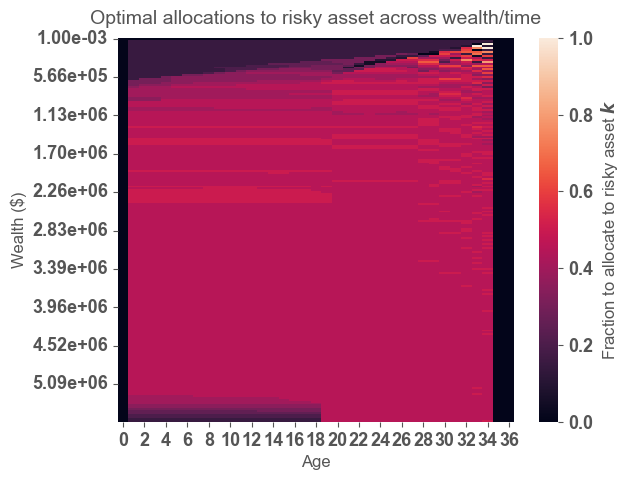

In [10]:
ax = sns.heatmap(K_opt.T)

ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Wealth ($)", fontsize=12)
ax.set_title("Optimal allocations to risky asset across wealth/time")
cbar = ax.collections[0].colorbar
cbar.set_label("Fraction to allocate to risky asset $k$", fontsize=12)

step = 20
yticks = np.arange(0, n_grid, step)
yticklabels = [f"{W_grid[i]:.2e}" for i in yticks]
plt.yticks(yticks + 0.5, yticklabels);

Observations:
- Broadly speaking, allocate roughly the same fraction of your wealth to the risky asset, independent of your age and spending. There are some edge effects but I don't know if those are numerical.
- If you have very low levels of wealth, you invest more in the riskless asset
- If you have very high levels of wealth, at early times, you also invest less in the risky asset. Don't really get why though.

In [11]:
C_opt.shape, W_grid.shape

optimal_consumption = np.einsum("ij,j->ij", C_opt, W_grid)

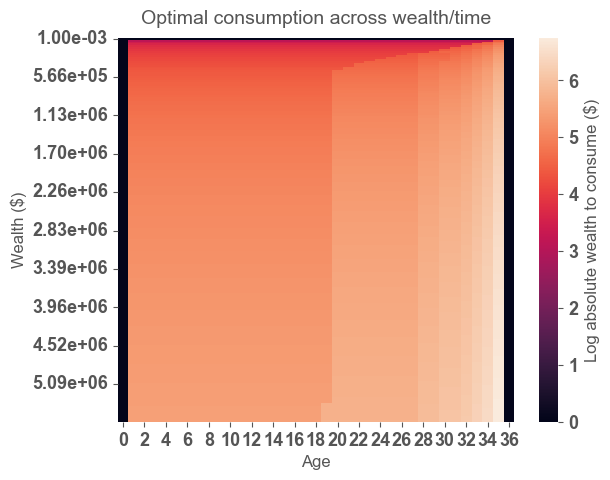

In [12]:
ax = sns.heatmap(np.log10(optimal_consumption.T+1))

ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Wealth ($)", fontsize=12)
ax.set_title("Optimal consumption across wealth/time")
cbar = ax.collections[0].colorbar
cbar.set_label("Log absolute wealth to consume ($)", fontsize=12)

step = 20
yticks = np.arange(0, n_grid, step)
yticklabels = [f"{W_grid[i]:.2e}" for i in yticks]
plt.yticks(yticks + 0.5, yticklabels);

## Analytic results from Haghani & White

This supports Haghani & White's claim:

The optimal rule for how much to invest in the risky asset is independent of both age and spending, under some simplifying assumptions (probably far from extremes outlined above). It turns out the optimal investment rule is the Merton share:

$$\hat{k} = \frac{\mu}{\gamma \sigma^2}$$

where $\hat{k}$ is the optimal fraction of wealth to invest in the risky asset, $\mu$ is the expected excess return of the risky asset, $\sigma$ is its standard deviation, and $\gamma$ is the investor's risk aversion.

Optimal spending for long horizons is

$$\hat{c}_{\infty} = r_{ra} - \frac{r_{ra} - r_{tp}}{\gamma}$$

where $r_{ra}$ is the risk-adjusted return of the optimal portfolio and $r_{tp}$ is the investor's rate of time preference.